# Modeling Notebook with Advanced NLP Techniques

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, utils
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import models, layers, optimizers
# from tensorflow.keras.utils.np_utils import to_categorical

import multiprocessing
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../py")
from utils import *



In [18]:
balanced = pickle.load(open("../pickle/balanced.pickle", "rb"))

In [20]:
balanced.head()

OptionError: "No such keys(s): 'mode.data_manager'"

In [12]:
train = pickle.load(open("../pickle/train_bal.pickle", "rb"))
val = pickle.load(open("../pickle/val_bal.pickle", "rb"))
test = pickle.load(open("../pickle/test_bal.pickle", "rb"))

TypeError: __cinit__() takes at least 2 positional arguments (0 given)

In [3]:
train.head()

,tweet,label
0,"[sexist, slightest, women, comedians, allow, a...",1
1,"[black, drivers, missouri, likely, stop, white...",1
2,"[agree, thats, worst, form, racism]",1
3,"[mollas, khokla, desh, bhakts, gandinaaliabuse]",1
4,"[people, way, association, assassination, die,...",1


In [4]:
val.head()

,tweet,label
0,"[pakistan, wear, black, band, oppose, israel, ...",1
1,"[winner, popular, vote, russian, conspiracy, r...",1
2,"[girl, fucktrump]",1
3,"[iphone, pocket, scratchy, things, scratch, sc...",1
4,"[beyonc, trash]",1


In [5]:
test['tweet2'] = test.tweet.apply(lambda x: str(x)[1:-1])
test.head()

,tweet,label,tweet2
0,"[people, faggot, like, bear, way, big, douche,...",1,"'people', 'faggot', 'like', 'bear', 'way', 'bi..."
1,"[far, girls, team, female, team, place, major,...",1,"'far', 'girls', 'team', 'female', 'team', 'pla..."
2,"[legally, force, parenthood]",1,"'legally', 'force', 'parenthood'"
3,"[simple, trumpisatraitor]",1,"'simple', 'trumpisatraitor'"
4,"[punishment, rapists, hang, till, death, publi...",1,"'punishment', 'rapists', 'hang', 'till', 'deat..."


In [117]:
train['label'] = train.target.apply(lambda x: str(x))
val['label'] = val.target.apply(lambda x: str(x))
test['label'] = test.target.apply(lambda x: str(x))

In [118]:
X_train = train.tweet
X_val = val.tweet
X_test = test.tweet
y_train = train.target
y_val = val.target
y_test = test.target

# Doc2Vec


## DBOW (Distributed Bag of Words)

In [62]:
train_tagged = train.apply(lambda x: TaggedDocument(words=x['tweet'], tags=[str(x.label)]), axis=1)
train_tagged.values[30]

TaggedDocument(words=['retard', 'bruh', 'lol'], tags=['1'])

In [64]:
val_tagged = val.apply(lambda x: TaggedDocument(words=x['tweet'], tags=[str(x.label)]), axis=1)
val_tagged.values[10]

TaggedDocument(words=['twitter', 'fag', 'youre', 'retard'], tags=['1'])

In [65]:
import multiprocessing
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 18586/18586 [00:00<00:00, 2860746.21it/s]


In [66]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 18586/18586 [00:00<00:00, 3130484.87it/s]
CPU times: user 18.3 s, sys: 2.92 s, total: 21.2 s
Wall time: 16.6 s


In [89]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_tr_dbow, X_tr_dbow = vec_for_learning(model_dbow, train_tagged)
y_val_dbow, X_val_dbow = vec_for_learning(model_dbow, val_tagged)

In [134]:
logreg = LogisticRegression(n_jobs=1, C=1e5).fit(X_tr_dbow, y_tr_dbow)
y_pred_dbow = logreg.predict(X_val_dbow)

get_metrics_3(X_val_dbow, y_val_dbow, y_pred_dbow, logreg)

Accuracy:  0.9365079365079365
F1:  0.1631205673758865
Recall:  0.10747663551401869
Precision:  0.3382352941176471
ROC-AUC:  0.7277473780818045
PR-AUC:  0.21781611220765443


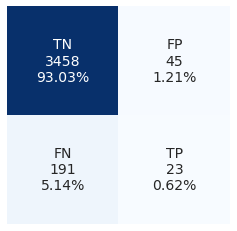

In [135]:
get_confusion(y_val_dbow, y_pred_dbow)

In [44]:
model_dbow.save('../data/d2v_model_dbow.doc2vec')
model_dbow = Doc2Vec.load('../data/d2v_model_dbow.doc2vec')

In [45]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMM (Distributed Memory Mean)

In [84]:
cores = multiprocessing.cpu_count()
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 18586/18586 [00:00<00:00, 2906395.28it/s]


In [85]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 18586/18586 [00:00<00:00, 3384065.56it/s]
CPU times: user 42 s, sys: 15.3 s, total: 57.3 s
Wall time: 42.7 s


In [50]:
model_dmm.save('../data/d2v_model_dmm.doc2vec')
model_dmm = Doc2Vec.load('../data/d2v_model_dmm.doc2vec')

In [86]:
model_dmm.most_similar('faggot')

[('fag', 0.46559789776802063),
 ('bitchman', 0.4648993909358978),
 ('cousintoucher', 0.46103107929229736),
 ('columbus', 0.45557713508605957),
 ('friendonly', 0.4523416757583618),
 ('bitchbitching', 0.45139026641845703),
 ('stephen', 0.4420473575592041),
 ('peacei', 0.4391942620277405),
 ('patrol', 0.43919339776039124),
 ('enemydont', 0.43444058299064636)]

In [132]:
y_tr_dmm, X_tr_dmm = vec_for_learning(model_dmm, train_tagged)
y_val_dmm, X_val_dmm = vec_for_learning(model_dmm, val_tagged)

logreg_2 = LogisticRegression().fit(X_tr_dmm, y_tr_dmm)
y_pred_dmm = logreg_2.predict(X_val_dmm)

get_metrics_3(X_val_dmm, y_val_dmm, y_pred_dmm, logreg_2)

Accuracy:  0.9195587839655637
F1:  0.31890660592255127
Recall:  0.32710280373831774
Precision:  0.3111111111111111
ROC-AUC:  0.749073557778246
PR-AUC:  0.24209600678282073


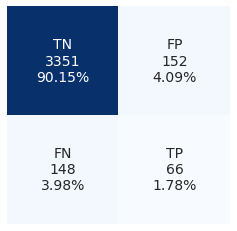

In [130]:
get_confusion(y_val_dmm, y_pred_dmm)

In [ ]:
abc_2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
    ).fit(X_tr_dmm, y_tr_dmm)
y_pred_abc_2 = abc_2.predict(X_val_dmm)
get_metrics_confusion(tfidf_val, y_val, y_pr_abc_val, abc)

# ANN with Tfidf Vectorizer

In [125]:
X_tr = X_train.values.sum()
X_val = X_val.values.sum()

In [143]:
# instantiate vectorizer object
tvec = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
tvec.fit(X_tr)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

In [145]:
# convert documents into matrix
X_train_tfidf = tvec.transform(X_tr)

In [146]:
X_val_tfidf = tvec.transform(X_val).toarray()

In [148]:
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [121731, 18586]

In [58]:
clf.score(x_valid_tfidf, y_val)

0.944578961528114

In [59]:
seed = 42
np.random.seed(seed)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [63]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield np.array(X_batch), np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

In [65]:
%%time
model = Sequential()
model.add(Dense(64, activation = 'relu', input_dim = 100000))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit_generator(generator = batch_generator(x_train_tfidf, y_tr, 32),
                    epochs = 10, 
                    random_state = 42, 
                    validation_data = (x_validation_tfidf, y_val),
                    steps_per_epoch = x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 23s 38ms/step - loss: 0.5717 - accuracy: 0.7947 - val_loss: 0.3167 - val_accuracy: 0.9424
Epoch 2/10
580/580 [==============================] - 21s 36ms/step - loss: 0.8485 - accuracy: 0.7785 - val_loss: 0.3863 - val_accuracy: 0.9424
Epoch 3/10
580/580 [==============================] - 23s 39ms/step - loss: 0.7411 - accuracy: 0.7924 - val_loss: 0.3191 - val_accuracy: 0.9424
Epoch 4/10
580/580 [==============================] - 22s 37ms/step - loss: 0.3069 - accuracy: 0.8735 - val_loss: 0.2377 - val_accuracy: 0.9432
Epoch 5/10
580/580 [==============================] - 23s 39ms/step - loss: 0.0923 - accuracy: 0.9696 - val_loss: 0.2436 - val_accuracy: 0.9422
Epoch 6/10
580/580 [==============================] - 21s 36ms/step - loss: 0.0611 - accuracy: 0.9816 - val_loss: 0.2560 - val_accuracy: 0.9414
Epoch 7/10
580/580 [==============================] - 21s 37ms/step - loss: 0.0481 - accuracy: 0.9845 - val_loss: 0.2701 - val_accuracy:

## Normalizing Inputs

In [66]:
from sklearn.preprocessing import Normalizer
norm = Normalizer().fit(x_train_tfidf)
x_train_tfidf_norm = norm.transform(x_train_tfidf)
x_validation_tfidf_norm = norm.transform(x_validation_tfidf)

In [69]:
%%time
model_n = Sequential()
model_n.add(Dense(64, activation = 'relu', input_dim = 100000))
model_n.add(Dense(1, activation ='sigmoid'))
model_n.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model_n.fit_generator(generator = batch_generator(x_train_tfidf_norm, y_tr, 32),
                      epochs = 10, 
                      validation_data = (x_validation_tfidf_norm, y_val),
                      steps_per_epoch = x_train_tfidf_norm.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 23s 38ms/step - loss: 0.5787 - accuracy: 0.7866 - val_loss: 0.3237 - val_accuracy: 0.9424
Epoch 2/10
580/580 [==============================] - 21s 36ms/step - loss: 0.8758 - accuracy: 0.7789 - val_loss: 0.4325 - val_accuracy: 0.9424
Epoch 3/10
580/580 [==============================] - 21s 36ms/step - loss: 0.8750 - accuracy: 0.7815 - val_loss: 0.3066 - val_accuracy: 0.9424
Epoch 4/10
580/580 [==============================] - 24s 40ms/step - loss: 0.3163 - accuracy: 0.8620 - val_loss: 0.2680 - val_accuracy: 0.9430
Epoch 5/10
580/580 [==============================] - 21s 36ms/step - loss: 0.1300 - accuracy: 0.9497 - val_loss: 0.2711 - val_accuracy: 0.9430
Epoch 6/10
580/580 [==============================] - 21s 37ms/step - loss: 0.0793 - accuracy: 0.9748 - val_loss: 0.2628 - val_accuracy: 0.9416
Epoch 7/10
580/580 [==============================] - 21s 36ms/step - loss: 0.0498 - accuracy: 0.9836 - val_loss: 0.2745 - val_accuracy:

## Using Dropout for Overfitting

In [71]:
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_dim=100000))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.fit_generator(generator=batch_generator(x_train_tfidf, y_tr, 32),
                    epochs=10, validation_data=(x_validation_tfidf, y_val),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 26s 44ms/step - loss: 0.5739 - accuracy: 0.7964 - val_loss: 0.3167 - val_accuracy: 0.9424
Epoch 2/10
580/580 [==============================] - 21s 36ms/step - loss: 0.8738 - accuracy: 0.7787 - val_loss: 0.3830 - val_accuracy: 0.9424
Epoch 3/10
580/580 [==============================] - 22s 37ms/step - loss: 0.8162 - accuracy: 0.7830 - val_loss: 0.2810 - val_accuracy: 0.9424
Epoch 4/10
580/580 [==============================] - 24s 40ms/step - loss: 0.3484 - accuracy: 0.8593 - val_loss: 0.2562 - val_accuracy: 0.9430
Epoch 5/10
580/580 [==============================] - 22s 38ms/step - loss: 0.1655 - accuracy: 0.9331 - val_loss: 0.2608 - val_accuracy: 0.9422
Epoch 6/10
580/580 [==============================] - 21s 36ms/step - loss: 0.1039 - accuracy: 0.9638 - val_loss: 0.2659 - val_accuracy: 0.9424
Epoch 7/10
580/580 [==============================] - 22s 37ms/step - loss: 0.0707 - accuracy: 0.9769 - val_loss: 0.2715 - val_accuracy:

## Shuffling Data

In [72]:
def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield np.array(X_batch), np.array(y_batch)
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

In [73]:
%%time
model_s = Sequential()
model_s.add(Dense(64, activation='relu', input_dim=100000))
model_s.add(Dense(1, activation='sigmoid'))
model_s.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_tr, 32),
                    epochs=10, validation_data=(x_validation_tfidf, y_val),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 25s 40ms/step - loss: 0.3838 - accuracy: 0.9369 - val_loss: 0.1864 - val_accuracy: 0.9414
Epoch 2/10
580/580 [==============================] - 23s 39ms/step - loss: 0.1334 - accuracy: 0.9441 - val_loss: 0.1732 - val_accuracy: 0.9430
Epoch 3/10
580/580 [==============================] - 24s 42ms/step - loss: 0.0648 - accuracy: 0.9769 - val_loss: 0.1909 - val_accuracy: 0.9381
Epoch 4/10
580/580 [==============================] - 25s 43ms/step - loss: 0.0299 - accuracy: 0.9927 - val_loss: 0.2163 - val_accuracy: 0.9397
Epoch 5/10
580/580 [==============================] - 23s 39ms/step - loss: 0.0198 - accuracy: 0.9950 - val_loss: 0.2417 - val_accuracy: 0.9392
Epoch 6/10
580/580 [==============================] - 21s 36ms/step - loss: 0.0166 - accuracy: 0.9955 - val_loss: 0.2558 - val_accuracy: 0.9379
Epoch 7/10
580/580 [==============================] - 23s 40ms/step - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.2735 - val_accuracy:

## Shuffle and Dropout

In [74]:
%%time
model_s_1 = Sequential()
model_s_1.add(Dense(64, activation='relu', input_dim=100000))
model_s_1.add(Dropout(0.2))
model_s_1.add(Dense(1, activation='sigmoid'))
model_s_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s_1.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_tr, 32),
                    epochs=10, validation_data=(x_validation_tfidf, y_val),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 29s 49ms/step - loss: 0.3737 - accuracy: 0.9375 - val_loss: 0.1844 - val_accuracy: 0.9416
Epoch 2/10
580/580 [==============================] - 23s 39ms/step - loss: 0.1436 - accuracy: 0.9445 - val_loss: 0.1730 - val_accuracy: 0.9430
Epoch 3/10
580/580 [==============================] - 24s 41ms/step - loss: 0.0717 - accuracy: 0.9730 - val_loss: 0.1895 - val_accuracy: 0.9392
Epoch 4/10
580/580 [==============================] - 24s 41ms/step - loss: 0.0349 - accuracy: 0.9903 - val_loss: 0.2123 - val_accuracy: 0.9381
Epoch 5/10
580/580 [==============================] - 23s 40ms/step - loss: 0.0222 - accuracy: 0.9943 - val_loss: 0.2310 - val_accuracy: 0.9370
Epoch 6/10
580/580 [==============================] - 24s 41ms/step - loss: 0.0169 - accuracy: 0.9946 - val_loss: 0.2546 - val_accuracy: 0.9370
Epoch 7/10
580/580 [==============================] - 23s 40ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.2672 - val_accuracy:

## Learning Rate

In [76]:
%%time
import keras
custom_adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_2 = Sequential()
model_testing_2.add(Dense(64, activation='relu', input_dim=100000))
model_testing_2.add(Dense(1, activation='sigmoid'))
model_testing_2.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_2.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_tr, 32),
                    epochs=10, validation_data=(x_validation_tfidf, y_val),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 37s 62ms/step - loss: 0.2616 - accuracy: 0.9293 - val_loss: 0.1741 - val_accuracy: 0.9424
Epoch 2/10
580/580 [==============================] - 28s 48ms/step - loss: 0.0662 - accuracy: 0.9629 - val_loss: 0.2558 - val_accuracy: 0.9292
Epoch 3/10
580/580 [==============================] - 26s 45ms/step - loss: 0.0250 - accuracy: 0.9921 - val_loss: 0.2860 - val_accuracy: 0.9244
Epoch 4/10
580/580 [==============================] - 27s 47ms/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.3190 - val_accuracy: 0.9341
Epoch 5/10
580/580 [==============================] - 32s 54ms/step - loss: 0.0114 - accuracy: 0.9958 - val_loss: 0.3377 - val_accuracy: 0.9319
Epoch 6/10
580/580 [==============================] - 29s 51ms/step - loss: 0.0097 - accuracy: 0.9964 - val_loss: 0.3698 - val_accuracy: 0.9349
Epoch 7/10
580/580 [==============================] - 30s 51ms/step - loss: 0.0097 - accuracy: 0.9956 - val_loss: 0.3596 - val_accuracy:

In [77]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_3 = Sequential()
model_testing_3.add(Dense(64, activation='relu', input_dim=100000))
model_testing_3.add(Dense(1, activation='sigmoid'))
model_testing_3.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_3.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_tr, 32),
                    epochs=10, validation_data=(x_validation_tfidf, y_val),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 41s 68ms/step - loss: 0.2273 - accuracy: 0.9414 - val_loss: 0.1879 - val_accuracy: 0.9424
Epoch 2/10
580/580 [==============================] - 31s 53ms/step - loss: 0.0512 - accuracy: 0.9808 - val_loss: 0.3134 - val_accuracy: 0.9338
Epoch 3/10
580/580 [==============================] - 28s 47ms/step - loss: 0.0187 - accuracy: 0.9926 - val_loss: 0.3171 - val_accuracy: 0.9322
Epoch 4/10
580/580 [==============================] - 28s 49ms/step - loss: 0.0140 - accuracy: 0.9937 - val_loss: 0.3170 - val_accuracy: 0.9190
Epoch 5/10
580/580 [==============================] - 28s 48ms/step - loss: 0.0110 - accuracy: 0.9949 - val_loss: 0.4019 - val_accuracy: 0.9384
Epoch 6/10
580/580 [==============================] - 29s 50ms/step - loss: 0.0084 - accuracy: 0.9960 - val_loss: 0.3401 - val_accuracy: 0.9252
Epoch 7/10
580/580 [==============================] - 29s 49ms/step - loss: 0.0072 - accuracy: 0.9965 - val_loss: 0.3432 - val_accuracy:

In [78]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_4 = Sequential()
model_testing_4.add(Dense(64, activation='relu', input_dim=100000))
model_testing_4.add(Dense(1, activation='sigmoid'))
model_testing_4.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_4.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_tr, 32),
                              epochs=10, 
                              validation_data=(x_validation_tfidf, y_val),
                              steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 42s 70ms/step - loss: 0.2224 - accuracy: 0.9356 - val_loss: 0.2158 - val_accuracy: 0.9405
Epoch 2/10
580/580 [==============================] - 31s 53ms/step - loss: 0.0872 - accuracy: 0.9680 - val_loss: 0.3700 - val_accuracy: 0.9368
Epoch 3/10
580/580 [==============================] - 27s 46ms/step - loss: 0.0549 - accuracy: 0.9832 - val_loss: 0.5258 - val_accuracy: 0.9349
Epoch 4/10
580/580 [==============================] - 34s 58ms/step - loss: 0.0346 - accuracy: 0.9886 - val_loss: 0.3928 - val_accuracy: 0.9354
Epoch 5/10
580/580 [==============================] - 28s 47ms/step - loss: 0.0260 - accuracy: 0.9903 - val_loss: 0.4796 - val_accuracy: 0.9349
Epoch 6/10
580/580 [==============================] - 40s 68ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.5224 - val_accuracy: 0.9327
Epoch 7/10
580/580 [==============================] - 37s 63ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.5153 - val_accuracy:

In [79]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_5 = Sequential()
model_testing_5.add(Dense(64, activation='relu', input_dim=100000))
model_testing_5.add(Dense(1, activation='sigmoid'))
model_testing_5.compile(optimizer=custom_adam,
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

model_testing_5.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_tr, 32),
                              epochs=10, 
                              validation_data=(x_validation_tfidf, y_val),
                              steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 59s 97ms/step - loss: 0.4546 - accuracy: 0.9351 - val_loss: 0.1989 - val_accuracy: 0.9424
Epoch 2/10
580/580 [==============================] - 36s 61ms/step - loss: 0.1671 - accuracy: 0.9451 - val_loss: 0.1752 - val_accuracy: 0.9430
Epoch 3/10
580/580 [==============================] - 44s 76ms/step - loss: 0.1145 - accuracy: 0.9497 - val_loss: 0.1758 - val_accuracy: 0.9435
Epoch 4/10
580/580 [==============================] - 31s 53ms/step - loss: 0.0658 - accuracy: 0.9778 - val_loss: 0.1864 - val_accuracy: 0.9400
Epoch 5/10
580/580 [==============================] - 33s 58ms/step - loss: 0.0375 - accuracy: 0.9899 - val_loss: 0.1997 - val_accuracy: 0.9384
Epoch 6/10
580/580 [==============================] - 34s 59ms/step - loss: 0.0262 - accuracy: 0.9928 - val_loss: 0.2136 - val_accuracy: 0.9376
Epoch 7/10
580/580 [==============================] - 38s 65ms/step - loss: 0.0166 - accuracy: 0.9957 - val_loss: 0.2261 - val_accuracy:

## Increasing number of hidden nodes

In [80]:
%%time
model_s_2 = Sequential()
model_s_2.add(Dense(128, activation='relu', input_dim=100000))
model_s_2.add(Dense(1, activation='sigmoid'))
model_s_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s_2.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_tr, 32),
                        epochs=10, 
                        validation_data=(x_validation_tfidf, y_val),
                        steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
580/580 [==============================] - 70s 113ms/step - loss: 0.3306 - accuracy: 0.9425 - val_loss: 0.1761 - val_accuracy: 0.9424
Epoch 2/10
580/580 [==============================] - 46s 79ms/step - loss: 0.1100 - accuracy: 0.9463 - val_loss: 0.1859 - val_accuracy: 0.9387
Epoch 3/10
580/580 [==============================] - 46s 79ms/step - loss: 0.0399 - accuracy: 0.9884 - val_loss: 0.2260 - val_accuracy: 0.9376
Epoch 4/10
580/580 [==============================] - 43s 74ms/step - loss: 0.0197 - accuracy: 0.9942 - val_loss: 0.2539 - val_accuracy: 0.9360
Epoch 5/10
580/580 [==============================] - 53s 92ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.2730 - val_accuracy: 0.9357
Epoch 6/10
580/580 [==============================] - 64s 110ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.2904 - val_accuracy: 0.9341
Epoch 7/10
580/580 [==============================] - 60s 103ms/step - loss: 0.0082 - accuracy: 0.9963 - val_loss: 0.3066 - val_accura